In [1]:
import os
import numpy as np
import fiona
import rasterio
import rasterio.mask
from rasterio.windows import Window
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import colors
from sklearn.model_selection import train_test_split

In [2]:
from rasterio.warp import calculate_default_transform, reproject, Resampling

def transform_crs(dst_crs, resolution):
    for year in [2010,2015]:
        path_bio = f"../data/raw/biomass/amazonia/{resolution}m" + f"mapbiomas-brazil-collection-70-amazonia-{year}.tif"
        with rasterio.open(path_bio) as src:
            transform, width, height = calculate_default_transform(
                src.crs, dst_crs, src.width, src.height, *src.bounds)
            kwargs = src.meta.copy()
            kwargs.update({
                'crs': dst_crs,
                'transform': transform,
                'width': width,
                'height': height
            })

            with rasterio.open(f"../data/interim/biomass/amazonia/{resolution}m/" + f"biomass_{year}.tif", 'w', **kwargs) as dst:
                for i in range(1, src.count + 1):
                    reproject(
                        source=rasterio.band(src, i),
                        destination=rasterio.band(dst, i),
                        src_transform=src.transform,
                        src_crs=src.crs,
                        dst_transform=transform,
                        dst_crs=dst_crs,
                        resampling=Resampling.nearest)
                
# function to load biomass data
def load_biomass_data(year, shape, resolution=250):
    path_bio = f"../data/interim/biomass/amazonia/{resolution}m/" + f"biomass_{year}.tif"
    with rasterio.open(path_bio) as src:
        out_meta = src.meta
        if shape is not None:
            bio_data, out_transform = rasterio.mask.mask(src, shape, crop=True)
            bio_data = bio_data.squeeze()
            out_meta.update({"driver": "GTiff",
                 "height": bio_data.shape[0],
                 "width": bio_data.shape[1],
                 "transform": out_transform})
        else:
            bio_data = src.read(1)
    return bio_data, out_meta

# function to transform labels to 1=forest, 2=non_forest, 0=unknown
def transform_to_labels(bio_data):
    class_dict = {1:0, 3:0, 4:0, 5:0,49:0, # forest
                10:1,11:1,12:1,32:1,29:1,13:1, 13:1, 50:1, # natural
                14:2,15:2,18:2,19:2,39:2,20:2,40:2,61:2,41:2,36:2,46:2,47:2,48:2,9:2,21:2, # farming
                22:3,23:3,24:3,30:3,25:3, # urban
                26:4,33:4,31:4, # water
                27:255,0:255} # unobserved
    bio_data_new = np.zeros_like(bio_data)
    for key, value in class_dict.items():
        bio_data_new[bio_data == key] = value
    return bio_data_new

def preprocess_data(path_bio_processed, dst_crs, resolution):
    transform_crs(path_bio_processed, dst_crs, resolution)

    all_years = [2010,2015]

    bio_data = []
    out_meta = []
    for year in all_years:
        bio_data_year, out_meta_year = load_biomass_data(year, None, path_bio_processed)
        bio_data_year = transform_to_labels(bio_data_year)
        bio_data.append(bio_data_year)
        out_meta.append(out_meta_year)

    # replace unobserved with previously observed
    for i in np.arange(1, len(bio_data)):
        previously_observed = (bio_data[i] == 255) & (bio_data[i-1] != 255)
        bio_data[i][previously_observed] = bio_data[i-1][previously_observed]

    # identify mask to changing labels
    mask = np.zeros_like(bio_data[0])
    mask[bio_data[0] == 255] = 255 # unobserved
    for i in np.arange(1, len(bio_data)):
        mask[(bio_data[i-1] == 4) & (bio_data[i] == 0)] = 1 # mask pixels water -> forest
        mask[(bio_data[i-1] == 0) & (bio_data[i] == 4)] = 1 # mask pixels forest -> water

        if i > 1: # mask forest <-> not forest <-> forest
            mask[(bio_data[i-2] == 0) & (bio_data[i-1] != 0) & (bio_data[i] == 0)] = 2

        mask[(bio_data[i-1] != 0) & (bio_data[i] == 0)] = 3  # non-forest -> forest

    with rasterio.open(path_bio_processed + "biomass_mask.tif", "w", **out_meta[0]) as dest:
        dest.write(np.expand_dims(mask, axis=0))

    # save
    for i, year in enumerate(all_years):
        with rasterio.open(path_bio_processed + f"biomass_{year}.tif", "w", **out_meta[i]) as dest:
            dest.write(np.expand_dims(bio_data[i], axis=0))

In [6]:
resolution = 250
dst_crs = 'EPSG:6933'
path_bio_processed = f"../data/processed/biomass/amazonia_250/"
preprocess_data(path_bio_processed, dst_crs, resolution)

# Load bio data

In [8]:
# function to load biomass data
def load_processed_biomass_data(year, shape, resolution=250):
    path_bio = f"../data/processed/biomass/amazonia_250/" + f"biomass_{year}.tif"
    with rasterio.open(path_bio) as src:
        out_meta = src.meta
        if shape is not None:
            nodata = 255
            bio_data, out_transform = rasterio.mask.mask(src, shape, crop=True, nodata=nodata)
            bio_data = bio_data.squeeze()
            out_meta.update({"driver": "GTiff",
                 "height": bio_data.shape[0],
                 "width": bio_data.shape[1],
                 "transform": out_transform})
        else:
            bio_data = src.read(1)
    return bio_data, out_meta

In [9]:
year = 2020
bio_data, bio_data_meta = load_processed_biomass_data(year, None, resolution=250)

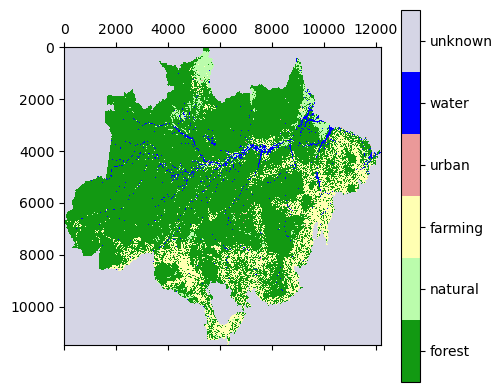

In [10]:
cmap = colors.ListedColormap(['#129912','#bbfcac', '#ffffb2', '#ea9999', '#0000ff', '#D5D5E5'])
mat = plt.matshow(bio_data,cmap=cmap,vmin = -.5, vmax = 5.5)
cax = plt.colorbar(mat, ticks=np.arange(0,6))
cax.ax.set_yticklabels(['forest', 'natural', 'farming', 'urban', 'water', 'unknown'])
plt.show()

# Compute raster

In [168]:
px_resolution = 250 # calculate from area
output_ha = 10000
output_px = np.sqrt(output_ha*10000)/px_resolution
input_px= 10 * output_px
delta = input_px - output_px

height = bio_data.shape[0]
width = bio_data.shape[1]

In [169]:
x = np.arange(1.5 * delta, width - 1.5 * delta, delta)
y = np.arange(1.5 * delta, height - 1.5 * delta, delta)
xv, yv = np.meshgrid(x, y)

bbox = []
for x, y in zip(xv.flatten(), yv.flatten()):
    window = bio_data[int(y-delta/2):int(y+delta/2), int(x-delta/2):int(x+delta/2)]
    forest_cover = np.count_nonzero(window == 0)/delta**2
    empty_cover = np.count_nonzero(window == 255)/delta**2
    if (forest_cover > 0) & (empty_cover < 0.8):
        bbox.append((x,y,forest_cover))

xv, yv, forest_cover = zip(*bbox)

bins = np.linspace(0,1,4)
forest_cover_bin = np.digitize(forest_cover, bins) - 1

data_grid = np.vstack([xv, yv, forest_cover, forest_cover_bin]).T
train_data, val_data = train_test_split(data_grid, test_size=0.1, random_state=42, stratify=data_grid[:,-1])

delete_indices = []
for point in val_data:
    for x_sign, y_sign in zip([+1,+1,+1,0,0,-1,-1,-1], [+1,0,-1,+1,-1,+1,0,-1]):
        indices = np.where((train_data[:,0] == point[0] - delta * x_sign) & (train_data[:,1] == point[1] - delta * y_sign))[0]
        if len(indices) > 0:
            delete_indices.append(indices[0])

dropped_data = train_data[delete_indices]
train_data = np.delete(train_data, delete_indices, axis=0)

In [170]:
unique_ppp = int(delta / output_px)**2
print("Dropped data: ", dropped_data.shape[0], dropped_data.shape[0]/len(forest_cover))
print("Train data: ", train_data.shape[0], train_data.shape[0]/len(forest_cover), train_data.shape[0]/(train_data.shape[0]+val_data.shape[0]), train_data.shape[0]*unique_ppp)
print("Val data: ", val_data.shape[0], val_data.shape[0]/len(forest_cover), val_data.shape[0]/(train_data.shape[0]+val_data.shape[0]), val_data.shape[0]*unique_ppp)

Dropped data:  391 0.6695205479452054
Train data:  258 0.4417808219178082 0.8138801261829653 20898
Val data:  59 0.10102739726027397 0.1861198738170347 4779


[ 74. 118. 392.]


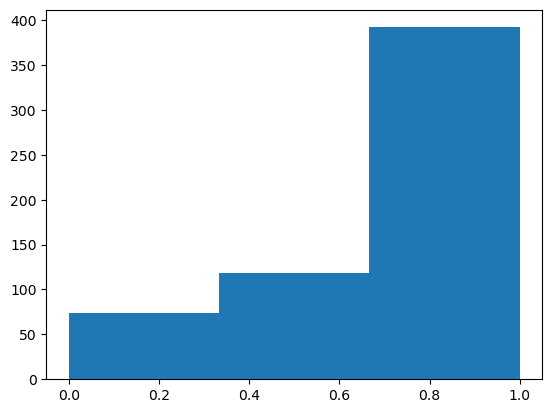

In [171]:
bin_box = plt.hist(forest_cover, bins=bins)
print(bin_box[0])
plt.show()

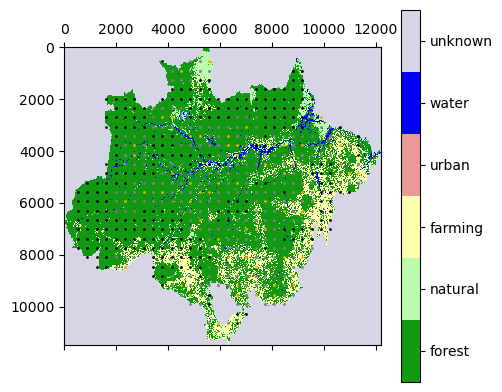

In [172]:
cmap = colors.ListedColormap(['#129912','#bbfcac', '#ffffb2', '#ea9999', '#0000ff', '#D5D5E5'])
mat = plt.matshow(bio_data,cmap=cmap,vmin = -.5, vmax = 5.5)
plt.scatter(val_data[:,0], val_data[:,1], s=1, c='orange')
plt.scatter(train_data[:,0], train_data[:,1], s=1, c='k')
plt.scatter(dropped_data[:,0], dropped_data[:,1], s=1, c='grey')
cax = plt.colorbar(mat, ticks=np.arange(0,6))
cax.ax.set_yticklabels(['forest', 'natural', 'farming', 'urban', 'water', 'unknown'])
plt.show()

# Transision data

In [68]:
from rasterio.warp import calculate_default_transform, reproject, Resampling

def transform_crs(dst_crs, resolution):
    for year_start, year_end in zip([2000,2005,2009,2010,2014,2015],[2010,2010,2010,2015,2015,2020]) :
        path_bio = f"../data/raw/biomass/amazonia/{resolution}m/" + f"mapbiomas-brazil-collection-70-amazonia-{year_start}_{year_end}.tif"
        with rasterio.open(path_bio) as src:
            transform, width, height = calculate_default_transform(
                src.crs, dst_crs, src.width, src.height, *src.bounds)
            kwargs = src.meta.copy()
            kwargs.update({
                'crs': dst_crs,
                'transform': transform,
                'width': width,
                'height': height
            })

            with rasterio.open(f"../data/interim/biomass/amazonia/{resolution}m/" + f"transition_{year_start}_{year_end}.tif", 'w', **kwargs) as dst:
                for i in range(1, src.count + 1):
                    reproject(
                        source=rasterio.band(src, i),
                        destination=rasterio.band(dst, i),
                        src_transform=src.transform,
                        src_crs=src.crs,
                        dst_transform=transform,
                        dst_crs=dst_crs,
                        resampling=Resampling.nearest)
                
# function to load biomass data
def load_biomass_data(year_start, year_end, shape):
    path_bio = f"../data/interim/biomass/amazonia/{resolution}m/" + f"transition_{year_start}_{year_end}.tif"
    with rasterio.open(path_bio) as src:
        out_meta = src.meta
        if shape is not None:
            bio_data, out_transform = rasterio.mask.mask(src, shape, crop=True)
            bio_data = bio_data.squeeze()
            out_meta.update({"driver": "GTiff",
                 "height": bio_data.shape[0],
                 "width": bio_data.shape[1],
                 "transform": out_transform})
        else:
            bio_data = src.read(1)
    return bio_data, out_meta

# function to transform labels to 1=forest, 2=non_forest, 0=unknown
def transform_to_labels(transition_data):
    forest_labels = [1,3,4,5,49]
    deforestation_labels = [14,15,18,19,39,20,40,61,41,36,46,47,48,9,21,
                            22,23,24,30,25]
    transition_labels = []
    for forest_label in forest_labels:
        for deforestation_label in deforestation_labels:
            transition_labels.append(100*forest_label+deforestation_label)
    transition_data_new = np.zeros_like(transition_data, dtype=bool)
    for transition_label in transition_labels:
        transition_data_new[transition_data == transition_label] = True
    return transition_data_new

# function to load biomass data
def load_processed_biomass_data(year_start, year_end, shape, resolution=250):
    path_bio = f"../data/processed/biomass/amazonia/{resolution}m/" 
    path_bio = path_bio + f"transition_{year_start}_{year_end}.tif"
    with rasterio.open(path_bio) as src:
        out_meta = src.meta
        if shape is not None:
            nodata = 255
            transition_data, out_transform = rasterio.mask.mask(src, shape, crop=True, nodata=nodata)
            transition_data = transition_data.squeeze().astype(bool)
            out_meta.update({"driver": "GTiff",
                 "height": transition_data.shape[0],
                 "width": transition_data.shape[1],
                 "transform": out_transform})
        else:
            transition_data = src.read(1).astype(bool)
    return transition_data, out_meta

def preprocess_data(dst_crs, resolution):
    # transform_crs(dst_crs, resolution)

    for year_start, year_end in zip([2000,2005,2009,2010,2014,2015],[2010,2010,2010,2015,2015,2020]):
        transition_data, out_meta = load_biomass_data(year_start, year_end, None)
        transition_data = transform_to_labels(transition_data)
     
        with rasterio.open(f"../data/processed/biomass/amazonia/{resolution}m/" + f"transition_{year_start}_{year_end}.tif", "w", **out_meta) as dest:
            dest.write(np.expand_dims(transition_data, axis=0))

    # missing transition map
    transition_2010_2015, _ = load_processed_biomass_data(2010, 2015, None, resolution=resolution)
    transition_2005_2010, out_meta = load_processed_biomass_data(2010, 2015, None, resolution=resolution)
    transition_2005_2015 = (transition_2010_2015|transition_2005_2010)
    with rasterio.open(f"../data/processed/biomass/amazonia/{resolution}m/" + f"transition_{2005}_{2015}.tif", "w", **out_meta) as dest:
            dest.write(np.expand_dims(transition_2005_2015, axis=0))


In [69]:
resolution = 250
dst_crs = 'EPSG:6933'
preprocess_data(dst_crs, resolution)

# Load transition data

In [70]:
year_start = 2005
year_end = 2015
transition_data, transition_data_meta = load_processed_biomass_data(year_start, year_end, None, resolution=250)

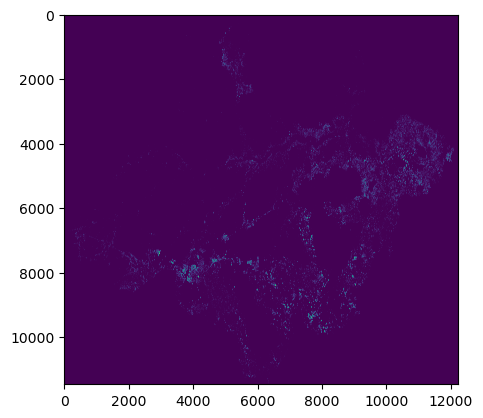

In [71]:
plt.imshow(transition_data)
plt.show()